<a href="https://www.kaggle.com/code/ivanderwijaya/atmosweather?scriptVersionId=246459850" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **AtmosWeather: AI-Powered Travel & Weather Intelligence**

## 🌎 **Overview**
AtmosWeather is an AI agent designed to **analyze real-time weather conditions**, integrate **real-time geolocation insights**, and provide **intelligent recommendations** using **Gemini LLM**. Built on **Kaggle**, this project acts as a **smart agent**, autonomously retrieving real-time weather forecasts, processing location-based data, and guiding users toward the best places to visit.

## **Motivation & Impact**
Activity planning can be challenging when conditions (e.g., weather) change rapidly or when event details are updated frequently. Our system uses generative AI to bridge multiple data sources and provide a unified recommendation. This approach is both innovative and timely—helping users make informed decisions.

## 📌 **Key Features**
- 🔹 **Real-Time Weather API Integration** – Fetches live weather data for any location.
- 🔹 **AI-Agent with Gemini LLM** – Processes weather insights and suggests travel decisions.
- 🔹 **Geolocation Assistance** – Uses mapping APIs to recommend spots based on conditions.
- 🔹 **Structured Output in JSON Mode** – Ensures organized data retrieval for AI processing.
- 🔹 **Function Calling & Few-shot Prompting** – Enhances the AI’s ability to refine responses.
- 🔹 **Grounding with Live Data Sources** – Prevents hallucinations by using factual information.

## 🔍 **How It Works**
1️⃣ **User Inputs a Query**.  
2️⃣ **Gemini LLM Analyzes Users Query** – The AI interprets the user query and plan action to generate relevant information for the user query.  
3️⃣ **Splitting the user Query** – Splitting the user query, did the agent need to ground the search or just fetch the weather or both
4 **Processing the splitted query** - After splitting the user query, the query will be processed accordingly
5 **Combining the splitted query and display it to user** - After the result was considered complete, the agent would print the response to the user

## 🌐 **Ideal Use Cases**
- ✈️ **Planning a Trip?** Get AI-powered suggestions for the best places to visit.
- 🌦️ **Checking Weather Before an Activity?** Find real-time climate insights.
- 🗺️ **Want Dynamic Travel Advice?** Use AI reasoning to navigate your options.

## 🎯 **Future Enhancements**
🔹 Integrating **historical weather trends** for predictive forecasting.  
🔹 Adding **image-based recognition** for landmark detection.  
🔹 Expanding **multi-city travel planning** using AI memory.

## Section 1: Problem Statement

Travelers and event-goers need a tool that tells them:
- **What events are happening?**
- **When are the best time to go to the events ?**
- **Where are these events, and what’s the weather like there?**

Traditional planning tools may offer static data, but our system dynamically connects to live weather APIs and search grounding to provide real-time insights.

## Section 2: System Architecture

Our system consists of three primary components:
1. **Query Classification Agent:** A dedicated LLM call that uses few-shot prompting to classify user queries into tasks (e.g., "grounding" vs. "weather").
2. **Grounding Engine:** A Gen AI call (using a Google Search tool) that extracts structured event and location details.
3. **Weather Retrieval Tool:** A local function or API call that provides current and forecast weather based on the extracted location.

A flowchart might appear like this: 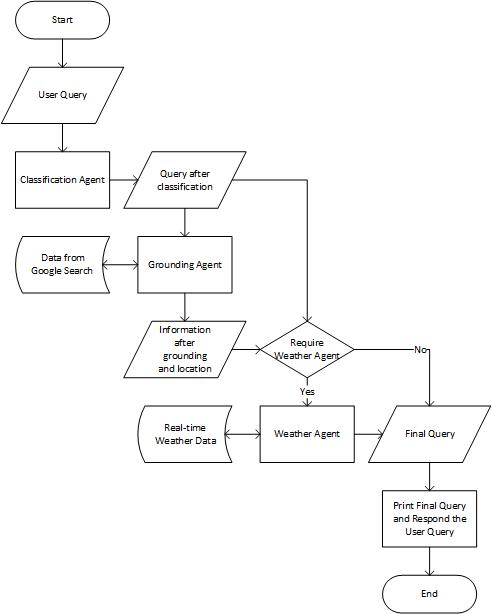

## Section 3: Code Implementation

### 3.1 API and Environment Setup

Here we will installing packages and removing packages that could be conflicting that were preinstalled in Kaggle notebook. We will also import necessary library for running the notebook.

In [ ]:
# Install required libraries
!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"
!pip install requests

# Import necessary libraries
import requests
import json
import re
import typing_extensions as typing
import google.genai.errors
from google import genai
from google.genai import types
from kaggle_secrets import UserSecretsClient
from google.api_core import retry

#### 🔑 **Setting Up API Keys for AtmosWeather**

AtmosWeather relies on **Google Gemini AI** and **OpenWeather API** to provide **AI-powered weather intelligence and travel recommendations**. To enable these services in your **Kaggle notebook**, you need to configure the API keys as **Kaggle secrets**.

##### **Step 1: Obtain API Keys**
Before running this notebook, ensure you have API access for both services:

- **Google Gemini AI API Key** → Get your key from [AI Studio](https://aistudio.google.com/app/apikey).  
- **OpenWeather API Key** → Sign up and obtain your key from [OpenWeather](https://openweathermap.org/api).  

You can also check the **official documentation** for more setup details:  
- Gemini API setup guide: [docs](https://ai.google.dev/gemini-api/docs/api-key)  
- OpenWeather API usage guide: [docs](https://openweathermap.org/api)

---

##### **Step 2: Add API Keys to Kaggle Secrets**
Once you have both keys, you need to **store them securely** using Kaggle’s secrets feature.

#### **To do this:**
1️⃣ Click on the **menu bar** at the top of the Kaggle notebook.  
2️⃣ Navigate to **Add-ons** > **Secrets**.  
3️⃣ Add the following secrets:
   - **`GEMINI_API_KEY`** → Your Google Gemini AI API key  
   - **`WEATHER_API_KEY`** → Your OpenWeather API key  

---

##### **Step 3: Verify API Key Availability in Notebook**
Once added, **make sure the keys are accessible** to your notebook before running the cells.

✅ **Select and mark your saved secrets** to enable them in the notebook.


In [ ]:
# Fetch API keys from Kaggle secrets
user_secrets = UserSecretsClient()
GEMINI_API_KEY = user_secrets.get_secret("GEMINI_API_KEY")
WEATHER_API_KEY = user_secrets.get_secret("WEATHER_API_KEY")

# Verify they are loaded correctly
print("Gemini API Key Loaded:", bool(GEMINI_API_KEY))
print("Weather API Key Loaded:", bool(WEATHER_API_KEY))

Next, we will initialize the Gemini AI client with the Gemini API key.

In [ ]:
# Initialize the Gemini client with the API key (ensure your Kaggle secret has GEMINI_API_KEY set)
client = genai.Client(api_key=GEMINI_API_KEY)

Finally, we will define a retry predicate to automatically retry the function if error `Quota Limit Reached` or similar happened when running this notebook

In [ ]:
# Define a predicate to check if an exception is retriable.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

### 3.2 Query Classification Agent
We first classify the query using an LLM call that outputs JSON, helping the agent understand and decide which specialized agent to delegate the task.

First, we will add class that would define how the query would be classified

In [ ]:
class QueryClassification(typing.TypedDict):
    requiresGrounding: bool
    requiresWeatherTools: bool
    groundingQuery: str
    weatherQuery: str

Next, we will create a function for the query classification agent that will breakdown the user query and classifies them into JSON structure that will define whether the user query need to be grounding and or need real-time weather data and will refine the queries that will sent to each of specialized agent.

In [ ]:
# --- Function 1: Classify the query ---
@retry.Retry(predicate=is_retriable)
def classify_query(query: str) -> dict:

    classification_prompt = """
You are an AI agent responsible for classifying user queries. 
Return a JSON object with:
- requiresGrounding: true if the query needs event/location grounding.
- requiresWeatherTools: true if a weather API call is required.
- groundingQuery: portion of the query that will be used for grounding with google search.
- weatherQuery: portion of the query that will be used for fetching weather using real-time API
Examples:
Input: "When and where is Swift's next concert? What's the weather like there?"
Output:
{
  "requiresGrounding": true,
  "requiresWeatherTools": true,
  "groundingQuery": "Find Swift's next concert",
  "weatherQuery": "Fetch current weather."
}

Input: "Tell me the forecast for Jakarta tomorrow"
Output:
{
  "requiresGrounding": false,
  "requiresWeatherTools": true,
  "groundingQuery": "Get the weather forecast for Jakarta on the next day.",
  "weatherQuery": "Fetch weather forecast for Jakarta for tomorrow."
}

Input: "Is it going to rain in Bandung today?"
Output:
{
  "requiresGrounding": false,
  "requiresWeatherTools": true,
  "groundingQuery": "Get the weather forecast for Bandung today.",
  "weatherQuery": "Fetch weather forecast for Bandung today."
}

Input: "How will the weather like in the next 3 days in Surabaya?"
Output:
{
  "requiresGrounding": false,
  "requiresWeatherTools": true,
  "groundingQuery": "Get the weather forecast for Surabaya in next 3 days.",
  "weatherQuery": "Fetch the weather forecast in Surabaya for the next 3 days."
}

Input: "Is it going to rain today in Sorong?"
Output:
{
  "requiresGrounding": false,
  "requiresWeatherTools": true,
  "groundingQuery": "Get the weather forecast for Sorong today.",
  "weatherQuery": "Fetch the current weather in Sorong for today."
}

Now, classify the following query:
""" + query

    classification_response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=classification_prompt,
        config=types.GenerateContentConfig(
            temperature=0.1,
            response_mime_type="application/json",
            response_schema=QueryClassification,  # Assuming you defined a TypedDict for this.
        ),
    )
    try:
        return json.loads(classification_response.text)
    except Exception as e:
        return {"error": "Classification failed", "details": str(e)}

### 3.3 Grounding Engine with Few-Shot JSON Examples

This agent specialized in grounding the user query that already refined before using Google Search to find latest and reliable information that available on Google. This agent is also extracting location information in the query if the user query did not mention location but after grounding search return a location of interest for the user that could be processed to the weather agent to get real-time weather data.

In [ ]:
# --- Function 2: Get grounding output ---
@retry.Retry(predicate=is_retriable)
def get_grounding(query: str) -> dict:
    few_shot_prompt = r"""
    Example 1:
Input Query: "When and where is Adel's next concert and what's the weather like there?"
Expected JSON Output:
{
  "info": "Adel's next nearest date concert is scheduled for July 15 at Madison Square Garden, New York.",
  "location": "New York",
  "time": July 15
}

Example 2:
Input Query: "When is the best time to go to national library Jakarta in the next 5 days?"
Expected JSON Output:
{
  "info": "National library in Jakarta typically opens around 10:00 AM until 17:00 PM all weeks, it is usually less crowded around 10:00 AM - 12:00 PM, it is recommended that you came before 12:00 PM",
  "location": Jakarta,
  "time": 10:00AM - 17:00PM
}

Example 3:
Input Query: "Where the best restaurant in San Francisco and what's the best time to visit based on the weather conditions?"
Expected Output:
{
  "info": "The most highly rated restaurant is Abe's restaurant located in Downtown Area, San Francisco opens at 7:00 AM until 10:00 PM, and the best time to visit is in the morning when the weather is clear.",
  "location": "San Francisco",
  "time": 7:00 AM - 10:00 PM
}

Example 4:
Input Query: "Tell me about climate change"
Expected Output:
{
  "info": "Climate change is a long-term change in the average weather patterns that have come to define Earth’s local, regional and global climates.",
  "location": null,
  "time": null
}

If a location name appears ambiguous (e.g., 'Central Park'), refer to additional context provided in the query (such as nearby landmarks like 'Mall' or regional indicators) before selecting the tool input. If context is insufficient, ask for clarification or prefer the local context inferred from the query.
If the information results in multiple time, select the time frame that the place of interest will be operating and insert that time frame in the time part of the JSON response.
Now, for the following query, provide only the JSON output with no extra text:
""" + query

    grounding_response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=few_shot_prompt,
        config=types.GenerateContentConfig(
            temperature=0.1,
            tools=[types.Tool(google_search=types.GoogleSearch())],
        ),
    )
    raw_output = grounding_response.candidates[0].content.parts[0].text.strip()
    # Clean up markdown fences if any.
    cleaned_output = re.sub(r"```(?:json)?", "", raw_output)
    cleaned_output = re.sub(r"```", "", cleaned_output).strip()
    try:
        return json.loads(cleaned_output)
    except Exception as e:
        return {"error": "Grounding failed", "details": str(e)}

### 3.4 Weather Forecast API Integration

This agent specialize in retrieving real-time weather data through third party weather data provider that provides accurate real-time weather data for the agent to use to give users accurate and real-time data that related to the user query in the context.

#### 3.4.1 Creating tools for the agent to use

In this section, we will create some tools that can be used by the Gemini AI to retrieve the real-time weather data and location from external sources

##### 3.4.1.1 Tools for fetch real-time weather data

This tools will be fetching current real-time weather for the weather agent to use

In [ ]:
# ---- Step 1: Define the Weather Tool Function that will be used by the Agent----
# 1. Current Weather Tool
def get_weather(city: str) -> dict:
    """
    Fetches real-time weather data for a given city using OpenWeather's API.
    This function returns the data in JSON format.
    """
    # Build the API URL; here we're using the OpenWeather endpoint
    weather_url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={WEATHER_API_KEY}&units=metric"
    response = requests.get(weather_url)
    if response.status_code != 200:
        return {"error": f"Unable to fetch weather data for {city}."}
    return response.json()

##### 3.4.1.2 Tools for fetch hourly forecast

This tools will be fetching future weather forecast with 3 hour intervals for the weather agent to use

In [ ]:
# 2. Hourly Forecast Tool
def get_hourly_forecast(city: str) -> dict:
    """
    Fetches hourly forecast data with 3-hour intervals.
    """
    url = f"http://api.openweathermap.org/data/2.5/forecast?q={city}&appid={WEATHER_API_KEY}&units=metric"
    response = requests.get(url)
    if response.status_code != 200:
        return {"error": f"Failed to retrieve hourly forecast for {city}"}
    return response.json()

##### 3.4.1.3 Tools for fetch real-time air pollution data

This tools will be fetching current real-time air pollution data for the weather agent to use

In [ ]:
# 3. Air Pollution Tool
def get_air_quality(city: str) -> dict:
    """
    Fetches the current air quality index (AQI) and related pollutants for a specified location.
    """    
    # Example endpoint; you'll need to adjust according to your API provider.
    url = f"http://api.airpollutionprovider.com/data/2.5/air_quality?http://api.openweathermap.org/data/2.5/air_pollution?q={city}&appid={AIR_POLLUTION_API_KEY}"
    response = requests.get(url)
    if response.status_code != 200:
        return {"error": f"Failed to retrieve air quality for {city}"}
    return response.json()


#### 3.4.2 Additional Tools for weather data

These tools were __additional__ and only usable if you have access to **Developer Plan** at [OpenWeather Plan](https://openweathermap.org/price) you can check about additional tools that enabled by OpenWeather API [here](https://openweathermap.org/api).

##### 3.4.2.1 Tools for fetch daily forecast weather data

This tools will be fetching future daily weather forecast up to 16 day for the weather agent to use

In [ ]:
# 1. Daily Forecast Tool
def get_daily_forecast(city: str) -> dict:
    """
    Fetches daily forecast data.
    Some APIs provide a dedicated daily forecast endpoint, or you can
    aggregate hourly data. This example assumes an API endpoint exists.
    """
    # Note: Check your weather API documentation if it offers a separate daily forecast endpoint.
    url = f"http://api.openweathermap.org/data/2.5/forecast/daily?q={city}&appid={WEATHER_API_KEY}&units=metric"
    response = requests.get(url)
    if response.status_code != 200:
        return {"error": f"Failed to retrieve daily forecast for {city}"}
    return response.json()

##### 3.4.2.2 Tools for fetch historical weather data

This tools will be fetching past weather forecast for the weather agent to use

In [ ]:
# 2. Historical Weather Data Tool
def get_historical_weather(city: str, timestamp: int) -> dict:
    """
    Fetches historical weather data for a given timestamp.
    You would need to provide the timestamp (in Unix format) for the date you
    want to retrieve information for.
    """
    url = f"http://api.openweathermap.org/data/2.5/onecall/timemachine?lat={city_lat}&lon={city_lon}&dt={timestamp}&appid={WEATHER_API_KEY}&units=metric"
    # Note: To use this endpoint, you must have the latitude and longitude of the city.
    response = requests.get(url)
    if response.status_code != 200:
        return {"error": f"Failed to retrieve historical weather for {city}"}
    return response.json()

##### 3.4.2.3 Tools for fetch weather alert data

This tools will be fetching current weather alert in that country for the weather agent to use

In [ ]:
# 3. Severe Weather Alerts Tool
def get_severe_weather_alerts(city: str) -> dict:
    """
    Fetches severe weather alerts for a city.
    This function assumes that the API endpoint returns weather alerts.
    """
    # This is an example URL; please adapt according to your weather provider.
    url = f"http://api.openweathermap.org/data/2.5/alerts?q={city}&appid={WEATHER_API_KEY}"
    response = requests.get(url)
    if response.status_code != 200:
        return {"error": f"Failed to retrieve weather alerts for {city}"}
    return response.json()

#### 3.4.3 Weather Agent

Finally, we will setup the agent and add previously created tools for the agent to use. If you have OpenWeather **Developer Plan**, you can uncomment the comment in the `weather_tools` and `instruction` to enable weather agent to use the additional tools that enabled by OpenWeather **Developer Plan** API.

In [ ]:
# ---- Initialize the Gemini Client and Set Up the Weather Agent ----
def setup_weather_agent() -> genai.chats.Chat:
    """
    Sets up the AtmosWeather LLM agent.
    This agent is configured to use the various weather tool to fetch real-time weather data.
    """
    
    # Define the list of available tools.
    weather_tools = [
    get_weather,
    get_hourly_forecast,
    get_air_quality,
    #Additional tools
    get_daily_forecast,
    get_historical_weather,
    get_severe_weather_alerts,
    ]
    
    # Define the system instruction that guides the agent's behavior.
    instruction = (
    "You are AtmosWeather, an AI travel assistant that integrates comprehensive weather data. "
    "You have access to several tools: \n"
    "- get_weather: Fetches the current weather for a specified location. \n"
    "- get_hourly_forecast: Provides a forecast in 3-hour increments for the upcoming hours up to 5 days ahead. \n"
    "- get_air_quality: Retrieves current air quality data including AQI and pollutant levels. \n\n"
    #Additional tools, uncomment only if you have developer plan on OpenWeather
    #"- get_daily_forecast: Returns a daily summary (max 7-day forecast) for planning longer trips. \n"
    #"- get_historical_weather: Retrieves past weather data given a timestamp and location. \n\n"
    #"- get_severe_weather_alerts: Retrieves alerts and warnings for severe weather conditions. \n"  
    "When a user asks for weather information or travel recommendations, determine which tool(s) to call. "
    "For example, if the user asks for the current weather and recommendations, use get_weather to get the weather condition and suggest places in the area of interest. "
    "However, if the query includes future time indicators such as 'tomorrow', 'next day', or 'next Saturday', do not use get_weather. Instead, always use the forecast tools (get_hourly_forecast or get_daily_forecast if available) to fetch future weather data up to 5 days ahead (for get_hourly_forecast) or 16 day (for get_daily_forecast, if available)."
    "If the query asks for recommendations (like when to leave), analyze the forecast and suggest an optimal time (e.g., 'It is better to come around 8:30 AM because the forecast predicts light rain later in the morning'). "
    "If the query involves outdoor activities, advise the best time to go based on both forecast and air pollution levels. "
    "Return responses in clear, user-friendly language that integrates the results from your tools as needed.\n\n"
    "Examples:\n"
    "Example 1:\n"
    "Query: \"When should I leave to visit Central Park tomorrow?\"\n"
    "Expected Output: \"Based on the forecast for tomorrow, it's best to leave around 8:30 AM since the weather will be clear with a light breeze, avoiding a mid-morning shower.\"\n\n"
    "Example 2:\n"
    "Query: \"What's the forecast for Jakarta Mall next Saturday?\"\n"
    "Expected Output: \"Next Saturday, expect partly cloudy skies with a high of 31°C. It might be ideal to visit around 10:00 AM to avoid afternoon heat.\"\n"
    )


    
    # Create the chat session with the agent. This configuration enables automatic function calling.
    chat_agent = client.chats.create(
        model="gemini-2.0-flash",
        config=types.GenerateContentConfig(
            system_instruction=instruction,
            tools=weather_tools,
        ),
    )
    return chat_agent

# Instantiate the weather agent. You only need to do this once.
weather_agent = setup_weather_agent()

## Section 4: Running & Testing Agent for Various Scenario

### 4.1 Orchestrator Agent

After we define and create specialized agent, we will create orchestrator agent to manage the agent workflow, so the user query could be processed step by step by agents we already created before.

In [ ]:
@retry.Retry(predicate=is_retriable)
def run_agent(query: str, verbose: bool = False) -> dict:
    # Step 1: Classify the query.
    if verbose:
        print(">> Classifying query:")
        print("Query:", query)
    classification_result = classify_query(query)
    if verbose:
        print(">> Classification result:")
        print(classification_result)
    
    if "error" in classification_result:
        if verbose:
            print(">> Error during classification. Returning error.")
        return classification_result

    # Initialize the combined result and store the refined query.
    combined_result = {"groundingQuery": classification_result.get("groundingQuery", query)}
    combined_result["weatherQuery"] = classification_result.get("weatherQuery", query)

    # Step 2: Get grounding.
    refined_query = classification_result.get("groundingQuery")
    weather_query = classification_result.get("weatherQuery")
    if not refined_query or not refined_query.strip():
        refined_query = query
        if verbose:
            print(">> Refined query was empty, falling back to original query.")
    
    if classification_result.get("requiresGrounding"):
        if verbose:
            print(">> requiresGrounding: True. Getting full grounding info (event & location).")
        grounding_result = get_grounding(refined_query)
        if verbose:
            print(">> Grounding result:")
            print(grounding_result)
        if "error" not in grounding_result:
            combined_result["event"] = grounding_result.get("info")
            location = grounding_result.get("location")
            time = grounding_result.get("time")
            combined_result["location"] = location
        else:
            combined_result["grounding_error"] = grounding_result.get("details")
            location = None
    else:
        if verbose:
            print(">> requiresGrounding: False. Extracting location only.")
        grounding_result = get_grounding(refined_query)
        if verbose:
            print(">> Grounding result:")
            print(grounding_result)
        if "error" not in grounding_result:
            location = grounding_result.get("location")
            time = grounding_result.get("time")
            combined_result["location"] = location
        else:
            combined_result["grounding_error"] = grounding_result.get("details")
            location = None

    # Step 3: Fetch weather if required.
    if classification_result.get("requiresWeatherTools") and location:
        if verbose:
            print(f">> Fetching weather for location: {location}")
        # Build the query parts dynamically.
        parts = []
        if weather_query:
            parts.append(weather_query)
        if location:
            parts.append("at " + location)
        if time:
            parts.append("around " + time)

        # Join the parts with spaces.
        final_query = " ".join(parts)

        # Now send the final_query.
        response = weather_agent.send_message(final_query)
        response_text = response.candidates[0].content.parts[0].text.strip()
        combined_result["weather"] = response_text
        if verbose:
            print(">> Weather response:")
            print(response_text)
    else:
        if verbose:
            print(">> Weather tool not required or location is missing.")

    # Final Outcome:
    if not classification_result.get("requiresGrounding"):
        if verbose:
            print(">> Grounding not required: returning weather result only.")
        return combined_result.get("weather", combined_result)
    else:
        if verbose:
            print(">> Grounding required: combining event and weather info.")
        # Note: If either "event" or "weather" is missing, concatenation might produce unexpected results.
        combined_text = combined_result.get("event", "") + combined_result.get("weather", "")
        if verbose:
            print(">> Final combined result:")
            print(combined_text)
        return combined_text

### 4.2 Testing the Agent

Finally, the agent were complete and could used for processing user query. 

Here we will be testing the Agent capability to respond to various simulated user query, you can add custom query by changing the query in the `user_query` and run the cell to get results from the agent.

You can also add `True` when calling the agent using `run_agent` to enable verbose mode for the output, so we can learn about how the agent process the user query until the result were printed to the user.

In [ ]:
## --- Example Usage: Asking about today weather ---
user_query = "Is it going to be raining today in Jakarta?"
result = run_agent(user_query)
print(result)

In [ ]:
## --- Example Usage: Asking about future weather forecast ---
user_query = "How the weather in Jakarta 20/04/2025, is there more cloud / rain / sunshine?"
result = run_agent(user_query)
print(result)

In [ ]:
## --- Example Usage: Asking about a venue operating hours ---
user_query = "When the Monas will be opening in the weekend?"
result = run_agent(user_query)
print(result)

In [ ]:
## --- Example Usage: Asking about when to left to go to a venue based on operating hour information and weather data ---
user_query = "When should I left to go to Gajah Mada Plaza tomorrow, is it going to rain?"
result = run_agent(user_query)
print(result)

In [ ]:
## --- Example Usage: Asking about weather trend by comparing year by year trend ---
user_query = "Is the weather in Jakarta in 2025 will be more warmer or more cooler than in 2024, can you be specific when is more warmer or colder?"
result = run_agent(user_query)
print(result)

In [ ]:
## --- Example Usage: Asking about an artist next concert and asking how the weather would be like at the concert day ---
user_query = "When Ado next concert in Japan, what the weather will like at that area?"
result = run_agent(user_query,True)
print(result)

In [ ]:
## --- Example Usage: Asking about an artist next concert and asking how the weather would be like at the concert day ---
user_query = "Based on current weather condition, suggest best place to go in Jakarta"
result = run_agent(user_query)
print(result)

## Section 5: Conclusion and Future Work

### Conclusion
* This project creatively merges generative AI with real-time data to create a dynamic travel assistant.

* This project showcases how Gen AI can be used not only to understand natural language queries but to orchestrate multiple API calls dynamically.

* This notebook is structured to explain the use case, methodology, and code in a clear and step-by-step manner. Detailed markdown sections accompany code cells to facilitate understanding.

### Future Work & Improvements
* Refine the query classification and grounding agent using more advanced NLP model and methods or fine-tuning the model so it could classify the data with less examples and therefore reducing token count and accelerate the infer process.

* Improve filtering to handle any inconsistencies in the grounding output.

* Deploying as a web app, to make the results more interactive using a single dashboard for the user to easily use and comprehend weather data.